In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
from abc import ABC, abstractmethod

### Create DataSet Classes

In [40]:
class LoadDataSet(ABC):
    @abstractmethod
    def load_data(self):
        pass
    
class NormalizeDataSet(ABC):
    @abstractmethod
    def normalize_data(self):
        pass
    
class EncodeDataSet(ABC):
    @abstractmethod
    def encode_data(self):
        pass
    
    

In [41]:
# Load the CIFAR-10 dataset using Keras
class CifarTenLoader(LoadDataSet):
    def load_data(self):
        return cifar10.load_data()

# Normalize the pixel values to the range [0, 1].
class CifarTenNormalize(NormalizeDataSet):
    def normalize_data(self,data:np.ndarray):
        return data.reshape((data.shape[0], 32, 32, 3)).astype('float32') / 255

# One-hot encode the labels. 
class CifarTenEncode(EncodeDataSet):
    def encode_data(self,labels):
        return to_categorical(labels)

In [42]:
# Load and Preprocess the Data 
class CifarTenDataset:
    def __init__(self,data_loader:LoadDataSet,data_normalize:NormalizeDataSet,data_encode:EncodeDataSet):
        self.data_loader = data_loader
        self.data_normalize = data_normalize
        self.data_encode = data_encode
        self.train_images = None
        self.test_images = None
        self.train_labels = None
        self.test_labels = None
        
    def load_and_preprocess_data(self):
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = self.data_loader.load_data()
        self.train_images=self.data_normalize.normalize_data(self.train_images)
        self.test_images=self.data_normalize.normalize_data(self.test_images)
        self.train_labels=self.data_encode.encode_data(self.train_labels)
        self.test_labels=self.data_encode.encode_data(self.test_labels)
        return self.train_images, self.train_labels, self.test_images, self.test_labels

### Load and Preprocess the Data

In [43]:
data_loader=CifarTenLoader()
normalize_data=CifarTenNormalize()
encode_data=CifarTenEncode()

In [44]:
preprocess_data=CifarTenDataset(data_loader,normalize_data,encode_data)
train_images, train_labels, test_images, test_labels=preprocess_data.load_and_preprocess_data()

### Visualization The Data

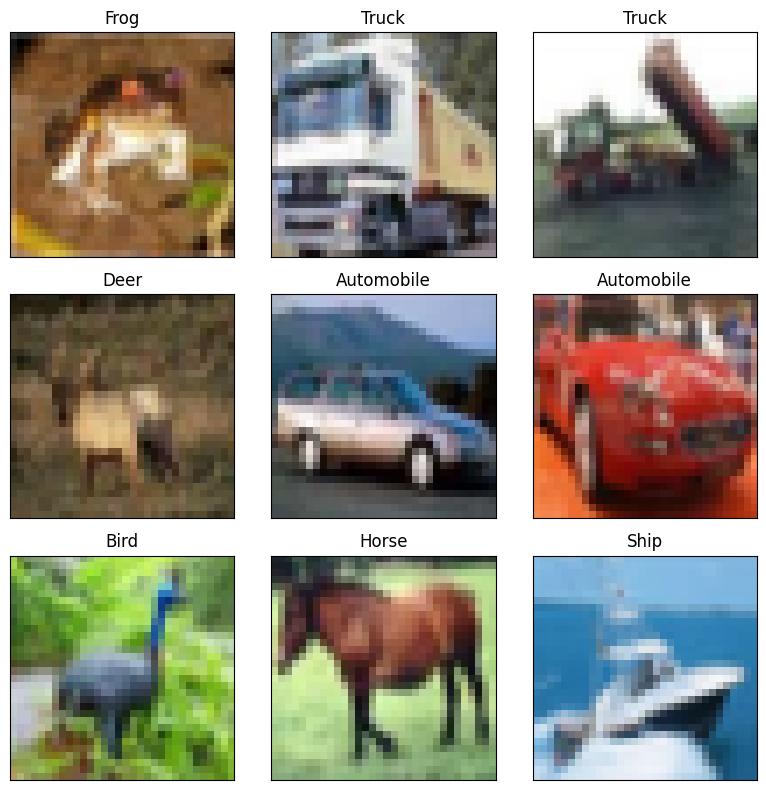

In [45]:
(images, labels), _ = data_loader.load_data()
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# Loop through images and plot
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])  # No cmap needed for RGB images
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(class_names[int(labels[i][0])])  # Fix label placement

# Adjust layout to fix spacing issues
plt.tight_layout()
plt.show()

### Create Model Classes

In [46]:
class BuildModel(ABC):
    @abstractmethod
    def build_model(self):
        pass

class TrainModel(ABC):
    @abstractmethod
    def train_model(self):
        pass

class EvaluateModel(ABC):
    @abstractmethod
    def evaluate_model(self):
        pass

In [47]:
from dataclasses import dataclass

@dataclass
class BuilderConfiguration:
    layers:list[layers.Layer]
    optimizer:str
    loss:str
    metrics:list[str]

@dataclass
class TrainConfiguration:
    model:Model
    train_data:np.ndarray
    train_labels:np.ndarray
    epochs:int
    batch_size:int
    validation_split:float
    
@dataclass
class EvaluationConfiguration:
    model:Model
    test_data:np.ndarray
    test_labels:np.ndarray
    

In [49]:
class CNNBuilder(BuildModel):
    def __init__(self,configuration:BuilderConfiguration):
        self.configuration = configuration
    
    def build_model(self):
        model = models.Sequential(self.configuration.layers)
        model.compile(optimizer=self.configuration.optimizer,
                      loss=self.configuration.loss,metrics=self.configuration.metrics)
        
        return model

class CNNTrain(TrainModel):
    def __init__(self,configuration:TrainConfiguration):
        self.configuration = configuration
    
    def train_model(self):
        history = self.configuration.model.fit(self.configuration.train_data,self.configuration.train_labels
                                               ,epochs=self.configuration.epochs,batch_size=self.configuration.batch_size
                                               ,validation_split=self.configuration.validation_split)
        return history

class CNNEvaluate(EvaluateModel):
    def __init__(self,configuration:EvaluationConfiguration):
        self.configuration = configuration
    
    def evaluate_model(self):
        test_loss, test_acc=self.configuration.model.evaluate(self.configuration.test_data,self.configuration.test_labels)
        return test_loss, test_acc